##### Copyright 2020 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Simple audio recognition: Recognizing keywords


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/simple_audio">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic [automatic speech recognition](https://en.wikipedia.org/wiki/Speech_recognition) (ASR) model for recognizing ten different words. You will use a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) ([Warden, 2018](https://arxiv.org/abs/1804.03209)), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

Real-world speech and audio recognition [systems](https://ai.googleblog.com/search/label/Speech%20Recognition) are complex. But, like [image classification with the MNIST dataset](../quickstart/beginner.ipynb), this tutorial should give you a basic understanding of the techniques involved.


## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.


In [2]:
# Step 1: Install TensorFlow and Datasets
%pip install -U -q tensorflow tensorflow_datasets

# Step 2: Install Wrapt
%pip install wrapt==1.14.1

# Step 3: Install Visualization Libraries
%pip install matplotlib seaborn

# Step 4: Install PySoundFile
%pip install pysoundfile

# Step 5: Reinstall TensorFlow I/O
# !pip uninstall -y tensorflow-io 
%pip install tensorflow-io
# %pip install --upgrade tensorflow

%pip install nbformat

# Step 6: Install IPykernel
%pip install ipykernel

%pip install ipynb

%pip install pickleshare

%pip install librosa



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pathlib
import glob
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
# import tensorflow_io as tfio
import pathlib
from IPython import get_ipython

TRAIN_DIR = pathlib.Path('data/small_train_ds')
# TRAIN_DIR = pathlib.Path('data/train_files')
TEST_DIR = pathlib.Path('data/small_test_ds')
# TEST_DIR = pathlib.Path('data/test_files')
DATA_DIR = pathlib.Path('data')
VAL_DIR = pathlib.Path('data/small_val_ds')


import ipynb.fs.defs.audio_extraction as audio_extraction
import ipynb.fs.defs.build_database as build_database
import ipynb.fs.defs.waveforms_to_spectrograms as wave_to_spec
import ipynb.fs.defs.build_train_model as build_train_model

# Extract

In [4]:
def notebook_extract():
    audio_extraction.extract_zip(TRAIN_DIR, DATA_DIR)
    print('-' * 50)  
    audio_extraction.extract_zip(TEST_DIR, DATA_DIR)
    print('-' * 50)  
    audio_extraction.extract_zip(VAL_DIR, DATA_DIR)
    print('-' * 50)
    print('-' * 50)  
    audio_extraction.rename_audio_files(DATA_DIR)
    print('-' * 50)
    print('-' * 50)  
    audio_extraction.process_directory(TRAIN_DIR) 
    audio_extraction.process_directory(VAL_DIR)
    audio_extraction.process_directory(TEST_DIR)  

notebook_extract()

Extrahiere die Zip-Datei data\small_train_ds.zip nach data.
Zip-Datei data\small_train_ds.zip erfolgreich extrahiert.
--------------------------------------------------
Extrahiere die Zip-Datei data\small_test_ds.zip nach data.
Zip-Datei data\small_test_ds.zip erfolgreich extrahiert.
--------------------------------------------------
Extrahiere die Zip-Datei data\small_val_ds.zip nach data.
Zip-Datei data\small_val_ds.zip erfolgreich extrahiert.
--------------------------------------------------
--------------------------------------------------
renaming of data/data complete
renaming of data/small_test_ds complete
renaming of data/orig complete
renaming of data/upscale complete
renaming of data/small_train_ds complete
renaming of data/orig-16-44-mono complete
renaming of data/upscale-from-mp3-128 complete
renaming of data/small_val_ds complete
renaming of data/orig-16-44-mono complete
renaming of data/upscale-from-mp3-128 complete
--------------------------------------------------
---

# Database

In [5]:
result = build_database.run(TRAIN_DIR, TEST_DIR, DATA_DIR, VAL_DIR)
file_list, example_labels, example_audio, train_ds, val_ds, test_ds, label_names, example_audio, example_labels, example_filenames = result

Found 10 files belonging to 2 classes.
Found 2 files belonging to 2 classes.

train_ds label names: ['orig-16-44-mono' 'upscale-from-mp3-128']
val_ds label names:   ['orig-16-44-mono' 'upscale-from-mp3-128']
(10, 320000)
(10,)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Index: 2
Dateiname: orig-16-44-mono_Medieval Theme.wav
Label im Dateinamen: orig-16-44-mono, Erwartetes Label: upscale-from-mp3-128
Vollstaendiger Dateipfad: orig-16-44-mono_Medieval Theme.wav
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Index: 4
Dateiname: orig-16-44-mono_Percussion Loop.wav
Label im Dateinamen: orig-16-44-mono, Erwartetes Label: upscale-from-mp3-128
Vollstaendiger Dateipfad: orig-16-44-mono_Percussion Loop.wav
--------------------------------------------------
Index: 5
Dateiname: upscale-from-mp3-128_11-Dark Fantasy Studio - 5 secondes de meditation.wav
Label im Dateinamen: upscale-from-mp3-128, Erwartetes Label: upscale-from-mp3-128
--------------------------------------------------
Inde

Let's plot a few audio waveforms:


i: 0
example_labels[i].numpy(): 0
i: 1
example_labels[i].numpy(): 0
i: 2
example_labels[i].numpy(): 1
i: 3
example_labels[i].numpy(): 0
i: 4
example_labels[i].numpy(): 1
i: 5
example_labels[i].numpy(): 1
i: 6
example_labels[i].numpy(): 1
i: 7
example_labels[i].numpy(): 0


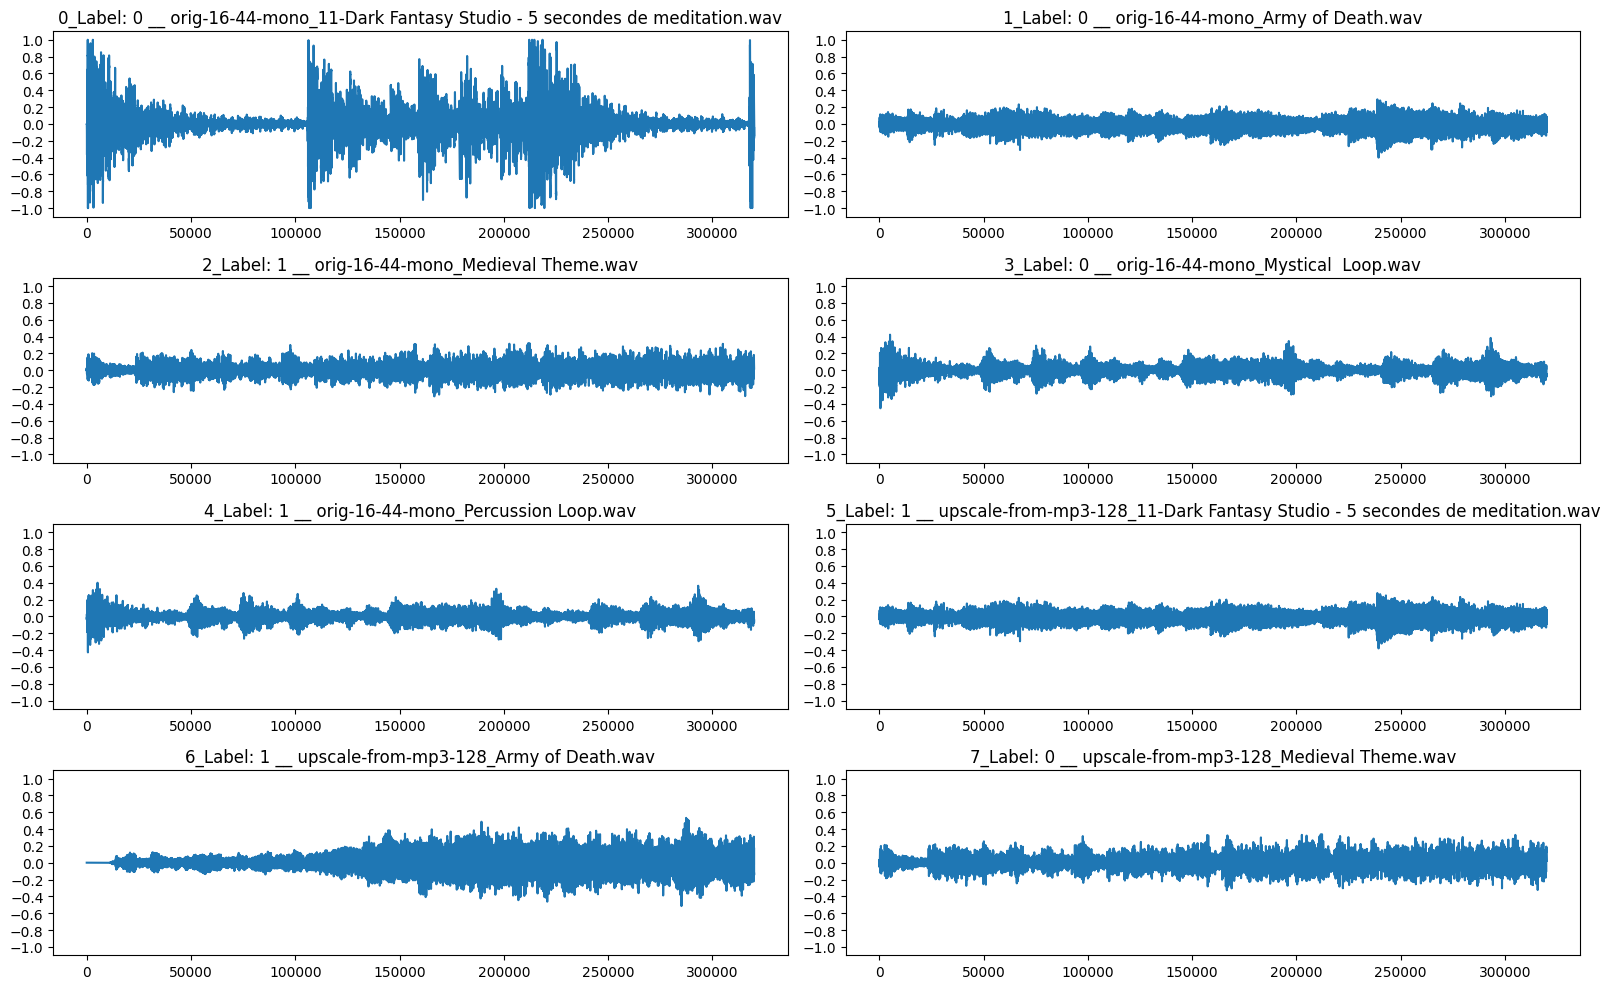

In [6]:
plt.figure(figsize=(16, 10))
rows = 4
cols = 2
n = rows * cols

for i in range(n):
    print("i:", i)
    print("example_labels[i].numpy():", example_labels[i].numpy())

    plt.subplot(rows, cols, i + 1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    label = example_labels[i].numpy()
    plt.title(f"{i}_Label: {label} __ {example_filenames[i]}")
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

plt.tight_layout() 
plt.show()

# Convert waveforms to spectrograms

Loaded label_names (before play): ['orig-16-44-mono' 'upscale-from-mp3-128']
Label: orig-16-44-mono
Waveform shape: (320000,)
Spectrogram shape: (2499, 129, 1)
Audio playback


Label: orig-16-44-mono
Waveform shape: (320000,)
Spectrogram shape: (2499, 129, 1)
Audio playback


Label: upscale-from-mp3-128
Waveform shape: (320000,)
Spectrogram shape: (2499, 129, 1)
Audio playback


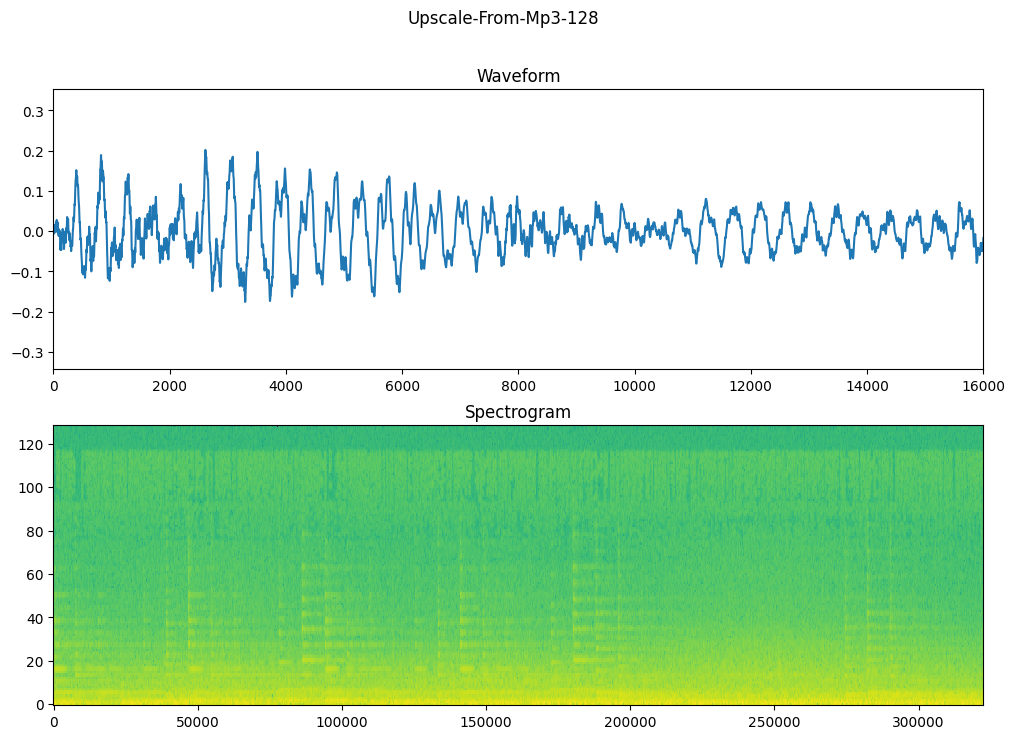

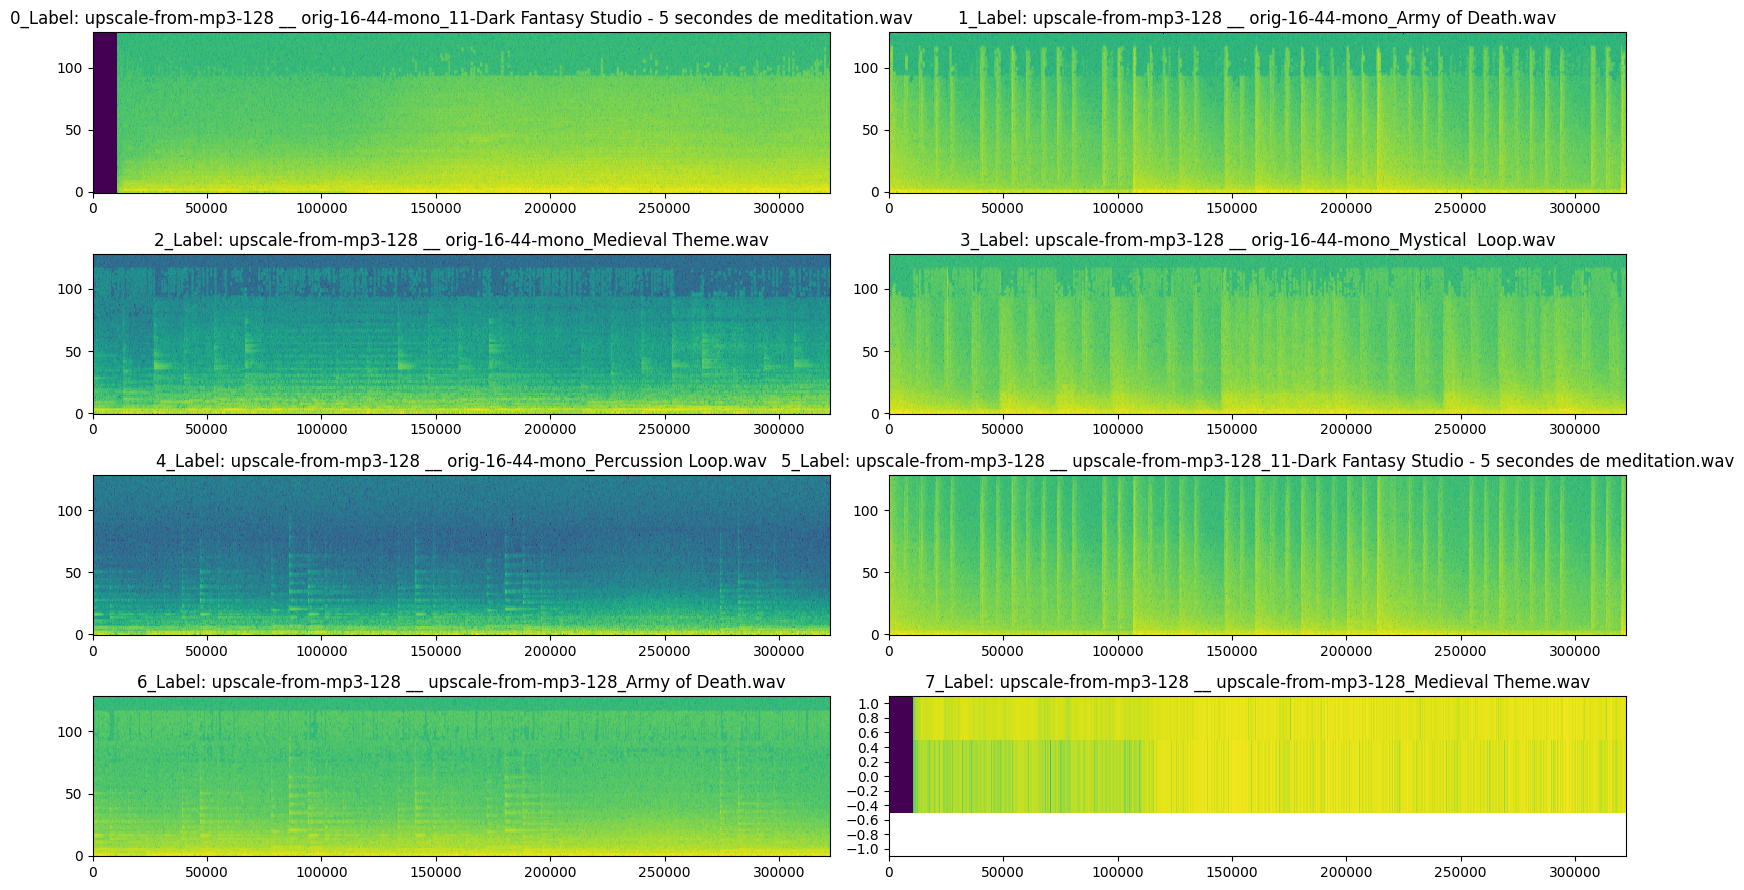

Loaded label_names (after play): ['orig-16-44-mono' 'upscale-from-mp3-128']


In [7]:
result = wave_to_spec.run(label_names, example_labels, example_audio, train_ds, val_ds, test_ds, example_filenames, file_list)
label_names, example_labels, example_audio, train_ds, val_ds, test_ds, example_filenames, waveform, file_list, train_spectrogram_ds,val_spectrogram_ds,test_spectrogram_ds, example_spectrograms,example_spect_labels = result

## Build and train the model


In [8]:
result = build_train_model.run(train_spectrogram_ds,val_spectrogram_ds,test_spectrogram_ds, example_spectrograms, label_names)
train_spectrogram_ds,val_spectrogram_ds,test_spectrogram_ds, example_spectrograms, label_names,  model, history = result

Input shape: (2499, 129, 1)
Cause: could not parse the source code of <function build_model.<locals>.<lambda> at 0x0000022BAEEA0A40>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function build_model.<locals>.<lambda> at 0x0000022BAEEA0A40>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,624,837 (6.20 MB)

 Trainable params: 1,624,834 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step - accuracy: 0.4000 - loss: 0.7051
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6000 - loss: 0.6763
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6000 - loss: 0.6203
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5000 - loss: 0.7098
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7000 - loss: 0.5873
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4000 - loss: 0.7102
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3000 - loss: 0.7803
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6000 - loss: 0.8059


c:\Users\prett\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
c:\Users\prett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6000 - loss: 0.7419
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6000 - loss: 0.7470
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5000 - loss: 0.7462
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4000 - loss: 0.8917
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4000 - loss: 0.8511
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4000 - loss: 0.7277
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6000 - loss: 0.6789
Epoch 16/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7000 - loss: 0.6509
Epoch 17/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7000 - loss: 0.6218
Epoch 18/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3000 - loss: 0.8190
Epoch 19/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7000 - loss: 0.6474
Epoch 20/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4

Let's plot the training and validation loss curves to check how your model has improved during training:


{'accuracy': [0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 0.5, 0.699999988079071, 0.4000000059604645, 0.30000001192092896, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.5, 0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 0.6000000238418579, 0.699999988079071, 0.699999988079071, 0.30000001192092896, 0.699999988079071, 0.4000000059604645, 0.4000000059604645, 0.5, 0.699999988079071, 0.4000000059604645, 0.5, 0.30000001192092896, 0.30000001192092896, 0.6000000238418579, 0.5, 0.6000000238418579, 0.5, 0.800000011920929, 0.30000001192092896, 0.5, 0.5, 0.5, 0.0, 0.4000000059604645, 0.5, 0.20000000298023224, 0.5, 0.5, 0.5, 0.6000000238418579, 0.30000001192092896, 0.5, 0.8999999761581421, 0.6000000238418579, 0.5, 0.699999988079071, 0.699999988079071, 0.10000000149011612, 0.699999988079071, 0.5, 0.5, 0.5, 0.30000001192092896, 0.4000000059604645, 0.6000000238418579, 0.699999988079071, 0.5, 0.5, 0.5, 0.4000000059604645, 0.699999988079071, 0.2000000029802322

Text(0, 0.5, 'Accuracy [%]')

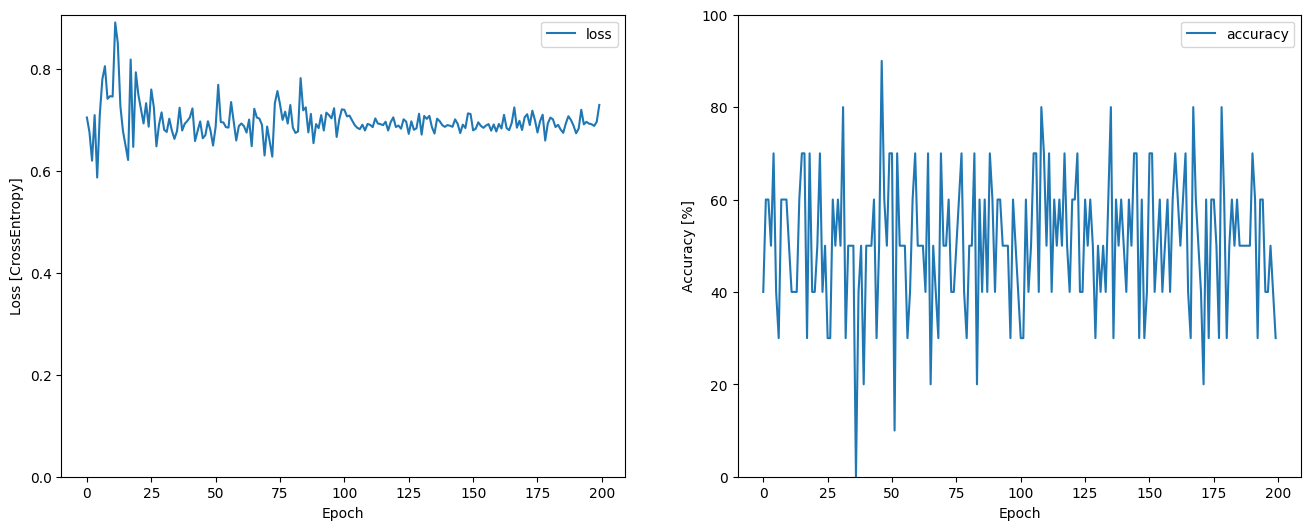

In [9]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
print(metrics)
# plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.plot(history.epoch, metrics['loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
# plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.plot(history.epoch, 100*np.array(metrics['accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:


In [10]:
model.evaluate(test_spectrogram_ds, return_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5000 - loss: 0.5136


{'accuracy': 0.5, 'loss': 0.5136392116546631}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


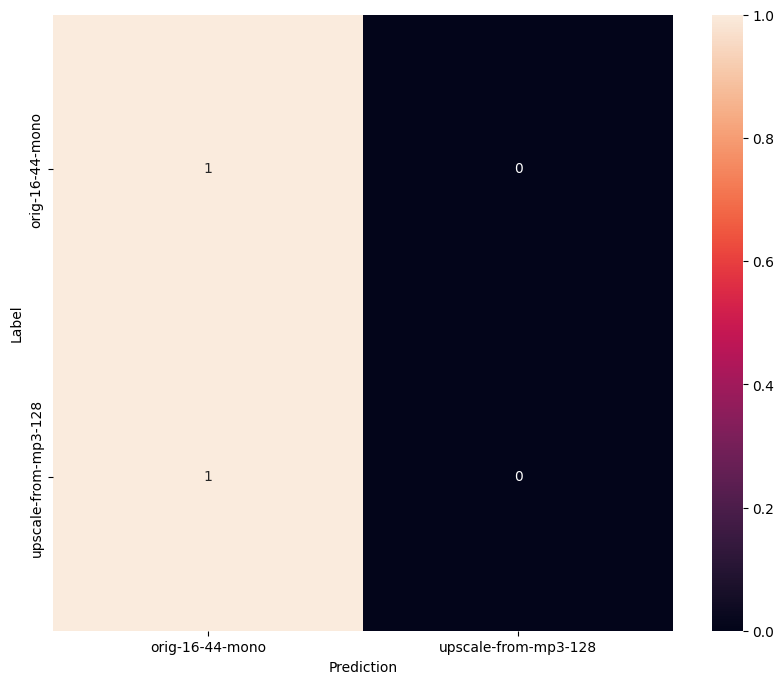

In [11]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?


Verarbeite Datei: data\small_test_ds\orig\orig_Fatality Racer.wav
File 'data\small_test_ds\orig\orig_Fatality Racer.wav' successfully decoded!
Form des Audiosignals: (16000,)
Sample Rate: 44100


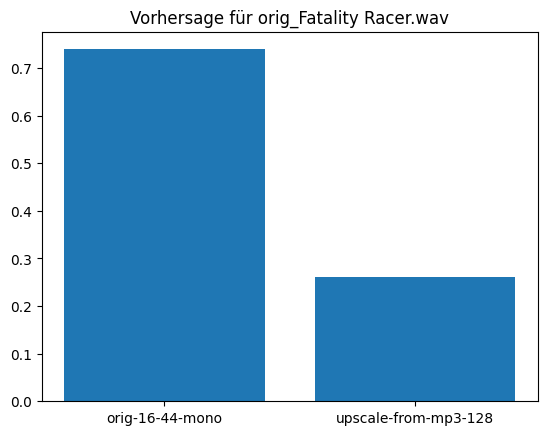

Verarbeite Datei: data\small_test_ds\upscale\upscale_Casual Theme Loop.wav
File 'data\small_test_ds\upscale\upscale_Casual Theme Loop.wav' successfully decoded!
Form des Audiosignals: (16000,)
Sample Rate: 44100


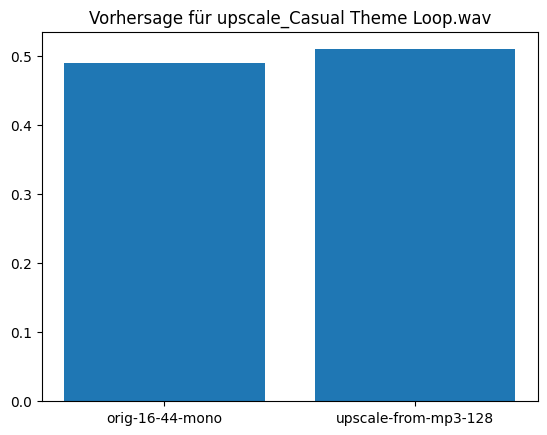

In [12]:
def visualize_audio(file_path):
    try:
        import ipynb.fs.defs.audio_extraction as audio_extraction
        audio, sample_rate = audio_extraction.load_wav_file_basic(file_path)
    except Exception as e:
        print(f"Could not process file '{file_path}': {e}")
        return
    # Entfernen der letzten Achse, falls nur ein Kanal vorliegt
    waveform = tf.squeeze(audio, axis=-1)

    print(f"Form des Audiosignals: {waveform.shape}")
    print(f"Sample Rate: {sample_rate}")

    spectrogram = wave_to_spec.get_spectrogram(waveform)

    # Dimension anpassen für das Modell
    input_tensor = spectrogram[tf.newaxis, ...]

    # Vorhersage des Modells
    prediction = model(input_tensor)

    # Labels für die Vorhersage
    x_labels = label_names  # Annahme: 'label_names' ist definiert

    # Balkendiagramm der Vorhersagen anzeigen
    plt.bar(x_labels, tf.nn.softmax(prediction[0]))
    plt.title(f'Vorhersage für {os.path.basename(file_path)}')
    plt.show()

    # Audio im Notebook abspielen
    display.display(display.Audio(waveform, rate=16000))

def process_directory_for_visualization(directory_path):
    # wav_files = glob.glob(os.path.join(directory_path, "*.wav"))
    for root, dirs, files in os.walk(directory_path):
        for file in files:    
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                print(f"Verarbeite Datei: {file_path}")
                visualize_audio(file_path)
            else:
                print("Keine WAV-Dateien im Verzeichnis gefunden.")
                return

# extract_zip(TEST_DIR, DATA_DIR)
# rename_audio_files(DATA_DIR)

process_directory_for_visualization(TEST_DIR)

## Export the model with preprocessing


The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:


In [13]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x = wave_to_spec.get_spectrogram(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:


In [14]:
export = ExportModel(model)
# export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))
export(tf.constant(str("../Tutorial/data/small_test_ds/orig/orig_Fatality Racer.wav")))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: '{' was never closed (<unknown>, line 1)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: '{' was never closed (<unknown>, line 1)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


{'predictions': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.68430215, -0.35875437]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'orig-16-44-mono'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:


In [15]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved\assets


INFO:tensorflow:Assets written to: saved\assets


ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (1 total):
    * <tf.Tensor 'x:0' shape=(1, 320000) dtype=float32>
  Keyword arguments: {}

 Expected these arguments to match one of the following 2 option(s):

Option 1:
  Positional arguments (1 total):
    * TensorSpec(shape=(), dtype=tf.string, name='x')
  Keyword arguments: {}

Option 2:
  Positional arguments (1 total):
    * TensorSpec(shape=(None, 16000), dtype=tf.float32, name='x')
  Keyword arguments: {}

## Next steps

This tutorial demonstrated how to carry out simple audio classification/automatic speech recognition using a convolutional neural network with TensorFlow and Python. To learn more, consider the following resources:

- The [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial shows how to use transfer learning for audio classification.
- The notebooks from [Kaggle's TensorFlow speech recognition challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview).
- The
  [TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0) teaches how to build your own interactive web app for audio classification.
- [A tutorial on deep learning for music information retrieval](https://arxiv.org/abs/1709.04396) (Choi et al., 2017) on arXiv.
- TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
- Consider using the [librosa](https://librosa.org/) library for music and audio analysis.
